This is adopted from: [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)
[https://github.com/wendykan/DeepLearningMovies](https://github.com/wendykan/DeepLearningMovies)


# Building a corpus of abstracts from historical (pre-1900) texts using NLP

### Importing necessary libraries
There are a lot of libraries to load here, and some may need to be installed. If you get an error, try 'pip install [Name of package]'

In [1]:
# needs to be annotated to tell what we use each package for
import re
import requests
import time
from Bio import Entrez
import nltk
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from collections import Counter
from textblob import TextBlob

The API for the historical texts will connect to the shared Google folder.  
Assisted by ChatGPT output.

In [2]:
# assume 'pip install PyDrive' has already been run
from pydrive.auth import GoogleAuth # to authenticate connection to Drive
from pydrive.drive import GoogleDrive # to read in files from Drive

In [4]:
# open an authenticated connection to Drive
gauth = GoogleAuth()
gauth.LoadClientConfigFile('/Users/eleanor/Documents/Fall 2023/Plants & Python/Unit4_FinalProject/2023PlantsAndPython/client_secret.json')
gauth.LocalWebserverAuth()  # For authentication using a local web server
drive = GoogleDrive(gauth) # this is the drive we'll be working with

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=177591520756-n0hgl0detjnphfoagmcabaic4s9ipl2i.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8090%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [20]:
def list_files(folder_id):
    all_files = []
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
    for file in file_list:
        if file['mimeType'] == 'text/plain':  # Filter for text files
            print('Title: %s, ID: %s' % (file['title'], file['id']))
            all_files.append({'title': file['title'], 'id': file['id'], 'type': 'file'})
        elif file['mimeType'] == 'application/vnd.google-apps.folder':  # If it's a folder, list its contents
            print('Folder:', file['title'])
            all_files.append({'title': file['title'], 'id': file['id'], 'type': 'folder'})  # Recursive call for subfolders
            # Recursive call to list_files for subfolders
            subfolder_files = list_files(file['id'])
            all_files.extend(subfolder_files)
    return all_files

In [21]:
# list_files('1mJs-l06xx4QbPj01tBtC0rXNeKxN2h6u')
print(list_files('1mJs-l06xx4QbPj01tBtC0rXNeKxN2h6u'))

Folder: Europe(needs 4 non-england ones to be done)
Title: the_principles_of_botany_and_of_vegetable_physiology.txt, ID: 1Ak5NavnxUBDpoAAA4OWO1UEzPM3Ku5G_
Title: Medicina_Britannica.txt, ID: 15kQnPsCdXXfEy9DiDLTPyUGrlzVCxFDk
Title: Continuacion_de_la_Flora_española_ó_Hi.txt, ID: 1_xw33krENssIFeKTCIUXU8pKvZxciaIC
Title: The_Agriculturalists_Manual.txt, ID: 1HaoVNoj3mEQZ1-7o08HLasffxSTLEI97
Title: Enquiry_into_Plants.txt, ID: 1JJvfJK1C1aRg-Ks6I4de2BBFzUvtWrWq
Title: The_Complete_Herbal.txt, ID: 1pXy_2vSmDqKnd7cbYuhg7CLaVASZ42Qf
Folder: North America(Needs 2 more to be 10)
Title: report_of_an_investigation_of_the_grasses_of_the_arid_districts_of_texas_new_mexico_Arizona_Nevada_and_Utah.txt, ID: 1oA_hTzw41ZPxK8uE16ER3MDY5uR2GjkZ
Title: Descriptions_of_plants_collected_by_William_Gambel,_M.D.,_in_the_Rocky_Mountains_and_Upper_California.txt, ID: 1_d2fHxEDFPXtDpkVGfqUOAJBzeL2xfnX
Title: A_popular_flora_of_Denver_Colorado.txt, ID: 1zZfpzEIX-7hdjmkTN0oj-wqZXIiloxtn
Title: American_Medicinal_

In [14]:
# def parse_string(content):
#     records = content.split('--------------------------------------------------\n')
#     parsed_records = []
    
#     for record in records:
#         if not record.strip():
#             continue
        
#         lines = record.strip().split('\n')
#         entry = {}
#         current_key = None
#         current_value = []

#         for line in lines:
#             if 'PMID: ' in line:
#                 entry['PMID'] = line.split(': ')[1].strip()
#             elif 'Year: ' in line:
#                 entry['Year'] = line.split(': ')[1].strip()
#             elif 'Title: ' in line:  
#                 continue
#             else:
#                 if line.startswith('Abstract: ') or line.startswith('Affiliations: '):
#                     if current_key:
#                         entry[current_key] = ' '.join(current_value).strip()
#                         current_value = []
#                     current_key = line.split(': ')[0]
#                     current_value.append(line.split(': ')[1].strip())
#                 else:
#                     current_value.append(line.strip())

#         if current_key:
#             entry[current_key] = ' '.join(current_value).strip()
        
#         parsed_records.append(entry)
    
#     return parsed_records

In [16]:
# Reading the text from a file named "pubmed_results.txt"
with open("pubmed_results.txt", "r", encoding="utf-8") as file:
    content = file.read()

records = parse_string(content)
df = pd.DataFrame(records)
df.head()  # Displays the top few rows of the dataframe

,PMID,Year,Abstract,Affiliations
0,37878015,2023,"Photosynthesis drives plant physiology, biomas...","Crop Science, Institute of Agricultural Scienc..."
1,37868001,2023,Protein concentrates obtained from discarded g...,"Instituto Politécnico Nacional, Centro Interdi..."
2,37852351,2023,Previous work demonstrated the utility of usin...,"Corteva Agrisciences, Johnston, IA, USA.; Muco..."
3,37844824,2023,A retrograded starch ingredient obtained from ...,"Academic Area of Nutrition, Institute of Healt..."
4,37842256,2023,Proteins play a vital role in human developmen...,"Faculty of Fisheries and Food Science, Univers..."


Note, our dataframe has four collumns for PMID, Yea, Abstract and affiliations. Next, we can do some plots and analyses of this. 

In [19]:
df.to_csv("bean.tsv", sep="\t", index=False)

In [20]:
abstracts_list = df['Abstract'].tolist()

Let's print the first 10 abstracts

In [21]:
print(abstracts_list[0:9])

["Photosynthesis drives plant physiology, biomass accumulation and yield. Photosynthetic efficiency, specifically the operating efficiency of photosystem II (Fq'/Fm'), is highly responsive to actual growth conditions, especially to fluctuating photosynthetic photon fluence rate (PPFR). Under field conditions, plants constantly balance energy uptake to optimize growth. The dynamic regulation complicates the quantification of cumulative photochemical energy uptake based on the intercepted solar energy, its transduction into biomass and the identification of efficient breeding lines. Here, we show significant effects on biomass related to genetic variation in photosynthetic efficiency of 178 climbing bean (Phaseolus vulgaris L.) lines. Under fluctuating conditions, the Fq'/Fm' was monitored throughout the growing period using hand-held and automated chlorophyll fluorescence phenotyping. The seasonal response of Fq'/Fm' to PPFR (ResponseG:PPFR) achieved significant correlations with biomas

Let's look at the distribution of when this data was published. 

C:\Users\15173\AppData\Local\Temp\ipykernel_29396\3978985952.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Year'] = df_filtered['Year'].astype(int)


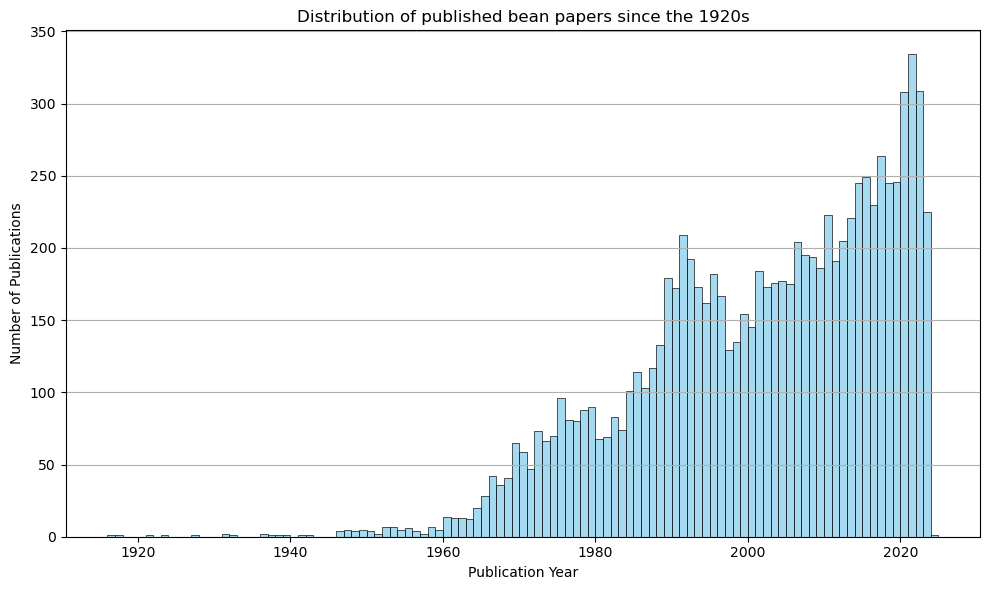

In [26]:
import seaborn as sns

# Convert 'N/A' to NaN
df['Year'] = df['Year'].replace('N/A', np.nan)

# Drop rows with NaN in 'Year' column for histogram plotting
df_filtered = df.dropna(subset=['Year'])

# Convert the 'Year' column of the filtered dataframe to integer type
df_filtered['Year'] = df_filtered['Year'].astype(int)

# Plot the histogram with seaborn
plt.figure(figsize=(10,6))
sns.histplot(data=df_filtered, x='Year', bins=range(df_filtered['Year'].min(), df_filtered['Year'].max() + 2), kde=False, color='skyblue')

plt.title('Distribution of published bean papers since the 1920s')
plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
We can also see how many pa

In [29]:
pip install pycountry

     --------------------------------------- 10.1/10.1 MB 10.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681895 sha256=595f098a6ae23e1f9fc7c2aab4adc96bbadd7cdd045913ac076112581a821c45
  Stored in directory: c:\users\15173\appdata\local\pip\cache\wheels\62\4a\9c\7a46699df9efb845aa116fae5e52d8690fc442fef6d32213f7
Successfully built pycountry
Note: you may need to restart the kernel to use updated packages.


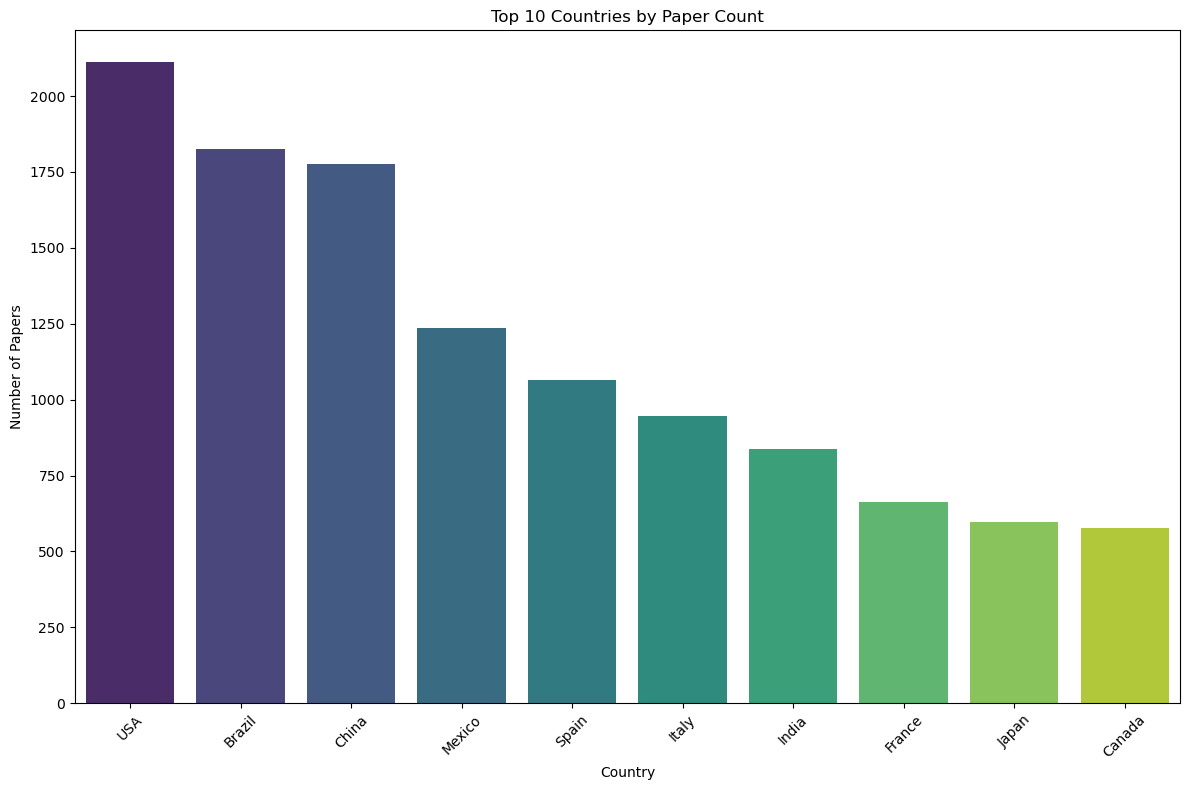

In [30]:
import pycountry
# Function to check if a string is a valid country name
def is_country(name):
    try:
        pycountry.countries.lookup(name)
        return True
    except:
        return False

# Explode and reset index
exploded_df = df['Affiliations'].str.split('[;,.]').explode().reset_index()
exploded_df.columns = ['original_index', 'Country']
exploded_df['Country'] = exploded_df['Country'].str.strip()

# Filter the valid countries
exploded_df = exploded_df[exploded_df['Country'].apply(is_country)]

# Count the occurrences and get the top 10
top_countries = exploded_df['Country'].value_counts().head(10)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')
plt.title('Top 10 Countries by Paper Count')
plt.xlabel('Country')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
#Now we are going to do our first class
class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review,"html.parser"  ).get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( KaggleWord2VecUtility.review_to_wordlist( raw_sentence, remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences


In [32]:
print ("Cleaning and parsing the training set movie reviews...\n")
num_reviews = len(abstracts_list)
clean_abstracts = []
for i in range( 0, len(abstracts_list)):
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews )  )  
    clean_abstracts.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(abstracts_list[i], True)))

Cleaning and parsing the training set movie reviews...

Review 1000 of 9138

Review 2000 of 9138

Review 3000 of 9138

Review 4000 of 9138

Review 5000 of 9138

Review 6000 of 9138

Review 7000 of 9138



C:\Users\15173\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Review 8000 of 9138

Review 9000 of 9138



In [33]:
clean_abstracts[0:5]

['photosynthesis drives plant physiology biomass accumulation yield photosynthetic efficiency specifically operating efficiency photosystem ii fq fm highly responsive actual growth conditions especially fluctuating photosynthetic photon fluence rate ppfr field conditions plants constantly balance energy uptake optimize growth dynamic regulation complicates quantification cumulative photochemical energy uptake based intercepted solar energy transduction biomass identification efficient breeding lines show significant effects biomass related genetic variation photosynthetic efficiency climbing bean phaseolus vulgaris l lines fluctuating conditions fq fm monitored throughout growing period using hand held automated chlorophyll fluorescence phenotyping seasonal response fq fm ppfr responseg ppfr achieved significant correlations biomass yield ranging two glasshouse three field trials respectively phenomic yield prediction outperformed genomic predictions new environments four trials rather

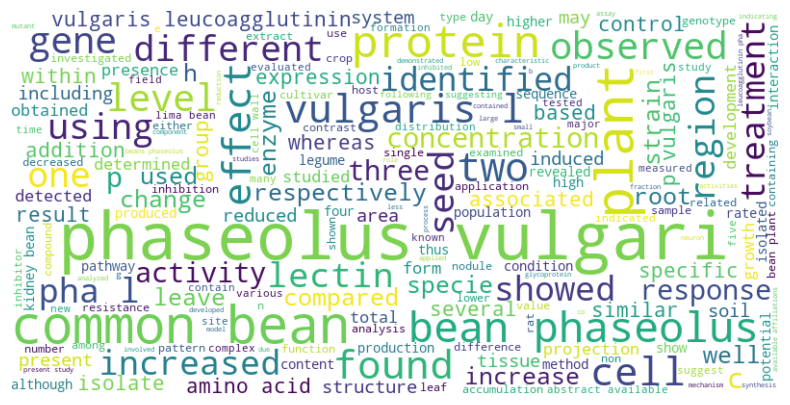

In [34]:
cleaned_abstracts = " ".join(clean_abstracts)
# Create a WordCloud object with custom settings
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=200).generate(cleaned_abstracts)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off axis labels
plt.show()

In [36]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [37]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("monologg/biobert_v1.1_pubmed")
model = BertModel.from_pretrained("monologg/biobert_v1.1_pubmed")


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

C:\Users\15173\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\15173\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/biobert_v1.1_pubmed were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
tokenizer = BertTokenizer.from_pretrained("monologg/biobert_v1.1_pubmed")

In [39]:
tokenized_abstracts = [tokenizer.tokenize(abstract) for abstract in clean_abstracts]

In [40]:
input_ids = [tokenizer.encode(abstract, add_special_tokens=True) for abstract in clean_abstracts]


Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


In [47]:
import torch

In [48]:
model.eval()

# Assuming you've already tokenized and encoded your abstracts as input_ids
abstract_embeddings = []

for ids in input_ids:
    with torch.no_grad():
        outputs = model(torch.tensor([ids]))  # the [0] is because we want the first element of the output tuple
        abstract_embeddings.append(outputs[0][0,0,:].numpy())  # Taking [CLS] token representation

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans

# Let's say you want to identify 10 clusters (topics). You can adjust this number as needed.
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(abstract_embeddings)

In [35]:
# Tokenizing the reviews
tokenized_reviews = [review.split() for review in clean_abstracts]

In [38]:
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

In [42]:
NUM_TOPICS = 10  # Adjust this based on your needs
lda_model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)

In [43]:
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.020*"bean" + 0.017*"beans" + 0.008*"p" + 0.007*"study" + 0.006*"g"')
(1, '0.012*"c" + 0.012*"acid" + 0.011*"phaseolus" + 0.011*"activity" + 0.010*"protein"')
(2, '0.014*"gene" + 0.013*"genes" + 0.012*"available" + 0.012*"expression" + 0.012*"abstract"')
(3, '0.019*"seed" + 0.014*"ga" + 0.011*"iron" + 0.009*"plants" + 0.008*"aba"')
(4, '0.013*"soil" + 0.012*"bean" + 0.012*"yield" + 0.010*"ozone" + 0.009*"l"')
(5, '0.023*"cells" + 0.019*"cell" + 0.014*"lectin" + 0.011*"pha" + 0.011*"binding"')
(6, '0.017*"plants" + 0.013*"growth" + 0.013*"root" + 0.011*"leaf" + 0.010*"leaves"')
(7, '0.013*"plants" + 0.013*"bean" + 0.012*"virus" + 0.008*"c" + 0.008*"l"')
(8, '0.020*"bean" + 0.016*"common" + 0.011*"resistance" + 0.008*"genetic" + 0.007*"vulgaris"')
(9, '0.022*"nucleus" + 0.012*"neurons" + 0.010*"lateral" + 0.010*"projections" + 0.008*"labeled"')


In [44]:
for i, review in enumerate(clean_abstracts[:10]):  # Displaying topics for the first 10 reviews
    bow = dictionary.doc2bow(review.split())
    topic_scores = lda_model[bow]
    dominant_topic = sorted(topic_scores, key=lambda x: x[1], reverse=True)[0]
    print(f"Review {i + 1} has dominant topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")

Review 1 has dominant topic 1 with probability 0.4567
Review 2 has dominant topic 5 with probability 0.5746
Review 3 has dominant topic 0 with probability 0.7041
Review 4 has dominant topic 0 with probability 0.7884
Review 5 has dominant topic 6 with probability 0.5061
Review 6 has dominant topic 0 with probability 0.6409
Review 7 has dominant topic 8 with probability 0.9945
Review 8 has dominant topic 6 with probability 0.4507
Review 9 has dominant topic 8 with probability 0.5978
Review 10 has dominant topic 0 with probability 0.5061


In [45]:
dominant_topics = []
for review in corpus:
    topic_scores = lda_model[review]
    dominant_topic = sorted(topic_scores, key=lambda x: x[1], reverse=True)[0][0]
    dominant_topics.append(dominant_topic)

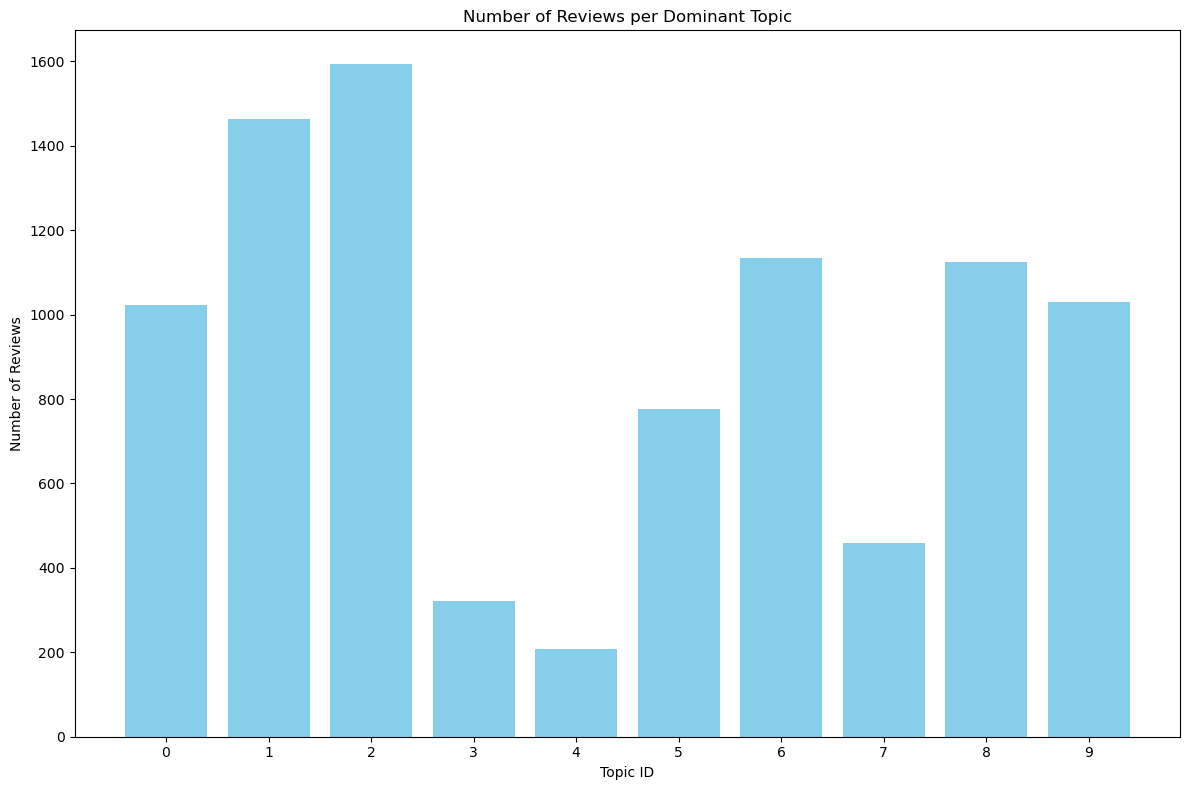

In [46]:
topic_counts = Counter(dominant_topics)
topics = list(topic_counts.keys())
counts = list(topic_counts.values())

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(topics, counts, color='skyblue', align='center')
plt.xlabel('Topic ID')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Dominant Topic')
plt.xticks(topics)  # Ensures that each topic ID gets its own tick on the x-axis
plt.tight_layout()
plt.show()

In [132]:

# Analyzing sentiments for each review in clean_train_reviews
sentiments = []

for review in clean_abstracts:
    blob = TextBlob(review)
    polarity = blob.sentiment.polarity
    # You can adjust these thresholds if desired
    if polarity > 0:
        sentiment = "positive"
    elif polarity < 0:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    sentiments.append(sentiment)

# Displaying the sentiment of the first few reviews
for review, sentiment in zip(clean_train_reviews[:5], sentiments[:5]):
    print(f"Review: {review}\nSentiment: {sentiment}\n")

Review: face climate change mosquitoes experience evolving climates including longer periods drought important physiological response dry environments protection water loss dehydration defined desiccation tolerance various environmental factors including temperature known alter interactions mosquito aedes aegypti arboviruses transmits little known low humidity impacts arboviral infection report gene upregulated response desiccation important controlling midgut infection identified two genetically diverse lines ae aegypti marked differences desiccation tolerance understand genetic basis underlying desiccation tolerance contrasting lines compared gene expression profiles desiccant treated non desiccant treated individuals desiccation tolerant susceptible lines rnaseq gene expression analysis demonstrates different genes differentially expressed response desiccation stress desiccation tolerant susceptible lines highly expressed transcript desiccation stress desiccation susceptible line en

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.85, max_features=25000, stop_words='english')
X = vectorizer.fit_transform(clean_abstracts)

In [48]:
from sklearn.cluster import KMeans

# Define the number of clusters you want
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

C:\Users\15173\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


This provides an idea of which cluster each review has been assigned to, helping you understand the grouping done by the KMeans algorithm.

Keep in mind that clustering, especially with text data, might not always give clear or meaningful clusters on the first try. You might need to experiment with different parameters, feature extraction methods, and even clustering algorithms to get the desired results.






In [49]:
from sklearn.manifold import TSNE

# Reduce the features to 2D
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=100)
tsne_features = tsne.fit_transform(X.toarray())  # Convert sparse matrix to dense


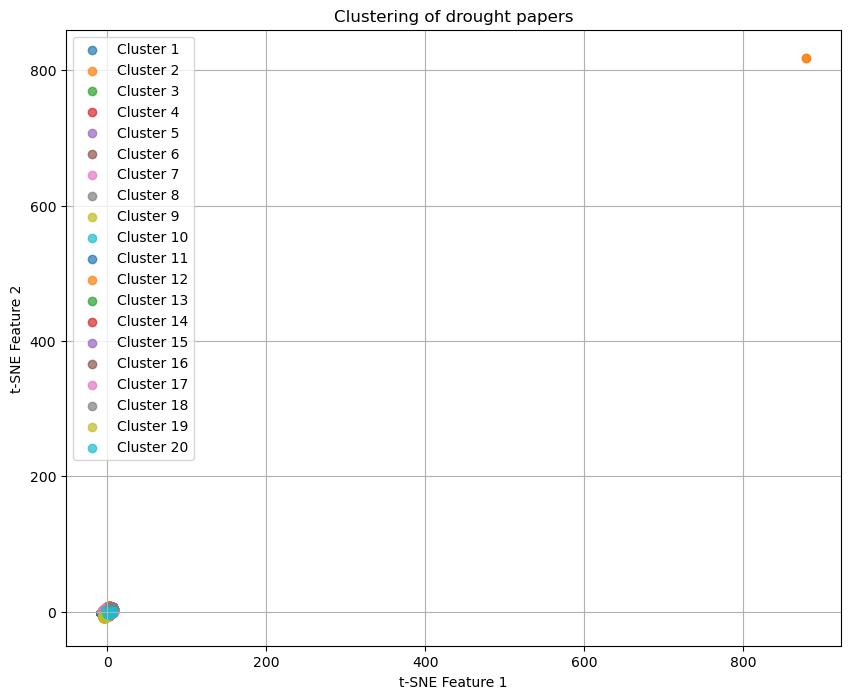

In [50]:
import matplotlib.pyplot as plt

# Plotting the 2D t-SNE results
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(tsne_features[clusters == i, 0], tsne_features[clusters == i, 1], label=f'Cluster {i+1}', alpha=0.7)

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('Clustering of drought papers')
plt.legend()
plt.grid(True)
plt.show()